In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

import models.graph_nn as grap

In [2]:
%load_ext autoreload
%autoreload 2

# data preprocessing

In [3]:
def normalize_features(particles):
    idx_pt, idx_eta, idx_phi, idx_class = range(4)
    # min-max normalize pt
    particles[:,:,idx_pt] = (particles[:,:,idx_pt] - np.min(particles[:,:,idx_pt])) / (np.max(particles[:,:,idx_pt])-np.min(particles[:,:,idx_pt]))
    # standard normalize angles
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_eta]))/np.std(particles[:,:,idx_eta])
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_phi]))/np.std(particles[:,:,idx_phi])
    # min-max normalize class label
    particles[:,:,idx_class] = (particles[:,:,idx_class] - np.min(particles[:,:,idx_class])) / (np.max(particles[:,:,idx_class])-np.min(particles[:,:,idx_class]))
    return particles

In [4]:
def normalized_adjacency(A):
    D = np.array(np.sum(A, axis=2), dtype=np.float32) # compute outdegree (= rowsum)
    D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))
    D = np.asarray([np.diagflat(dd) for dd in D]) # and diagonalize
    return np.matmul(D, np.matmul(A, D))

In [5]:
def make_adjacencies(particles):
    real_p_mask = particles[:,:,0] > 0
    adjacencies = (real_p_mask[:,:,np.newaxis] * real_p_mask[:,np.newaxis,:]).astype('float32')
    return adjacencies

# load data

In [6]:
filename = '/home/kinga/dev/datasamples/L1_anomaly_challenge/background_training_500K.h5'
ff = h5py.File(filename, 'r')
particles = np.asarray(ff.get('Particles'))

In [7]:
particles.shape

(500000, 19, 4)

In [8]:
nodes_n = particles.shape[1]
feat_sz = particles.shape[2]

In [9]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
batch_size = 128
particles_train = particles[:batch_size*20]

In [10]:
A = make_adjacencies(particles_train)
A_tilde = normalized_adjacency(A)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'pt')

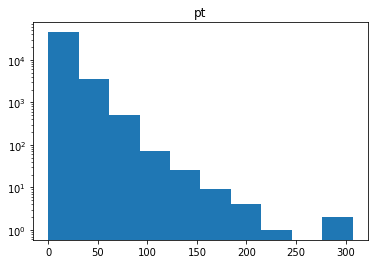

In [11]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')
plt.title('pt')

In [12]:
particles_train = normalize_features(particles_train)

Text(0.5, 1.0, 'normalized pt')

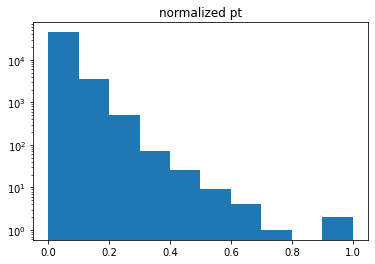

In [13]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

# build model: Autoencoder

In [14]:
gnn = grap.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 19, 19)]     0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 19, 3)        12          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 19, 2)        6           graph_convolution[0][0

# train model

In [15]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
gnn.fit((particles_train, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6742
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6739
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6738
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6738
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 8/100
15/15 [==============================] - 0s 17ms/step - val_loss: 0.6738
Epoch 9/100
14/15 [===========================>..] - ETA: 0s
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 10/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 11/100
15/15 [=

15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 76/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 77/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 78/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 79/100
14/15 [===========================>..] - ETA: 0s
Epoch 00079: ReduceLROnPlateau reducing learning rate to 3.0517577442878974e-07.
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6738
Epoch 80/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 81/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 82/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 83/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 84/100
15/15 [==============================] - ETA: 0s
Epoch 00084: ReduceLROnPlateau reducing learnin

# predict background

In [16]:
particles_test = particles[2000:3000]
A_test = make_adjacencies(particles_test)
A_tilde_test = normalized_adjacency(A_test)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
z, A_pred = gnn((particles_test, A_tilde_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [18]:
A_reco = (tf.nn.sigmoid(A_pred) > 0.5).numpy().astype('int') 

In [19]:
loss_background = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_test, A_pred), axis=(1,2))

In [20]:
np.mean(loss_background)

0.6927582

# load and predict signal

In [21]:
filename = '/home/kinga/dev/datasamples/L1_anomaly_challenge/hToTauTau_13TeV_PU20.h5'
ff = h5py.File(filename, 'r')
particles_signal = np.asarray(ff.get('Particles'))

In [22]:
particles_signal.shape

(691283, 19, 4)

In [23]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
particles_signal_test = particles_signal[:3000]

In [24]:
A_signal = make_adjacencies(particles_signal_test)
A_tilde_signal = normalized_adjacency(A_signal)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


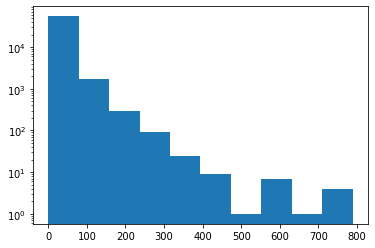

In [25]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')

In [26]:
particles_signal_test = normalize_features(particles_signal_test)

Text(0.5, 1.0, 'normalized pt')

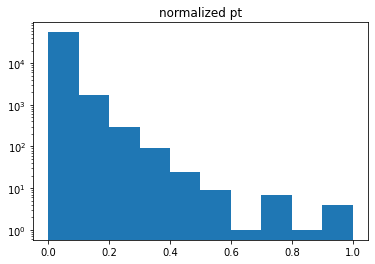

In [27]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

In [28]:
z_signal, A_pred_signal = gnn((particles_signal_test, A_tilde_signal))

In [29]:
A_reco_signal = (tf.nn.sigmoid(A_pred_signal) > 0.5).numpy().astype('int') 

In [30]:
loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal, A_pred_signal), axis=(1,2))

In [31]:
np.mean(loss_signal)

0.693138

# build model: Variational Autoencoder

In [32]:
gnn = grap.GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

# train model

In [33]:
len(particles_train)

2560

In [58]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
gnn.fit((particles_train, A_tilde), A, epochs=100, batch_size=batch_size, validation_split=0.25)

Epoch 1/100
15/15 [==============================] - 0s 18ms/step - loss: 0.7996 - loss_reco: 0.7974 - loss_latent: 0.0022 - val_loss: 0.8065 - val_loss_reco: 0.8045 - val_loss_latent: 0.0020
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.7990 - loss_reco: 0.7968 - loss_latent: 0.0022 - val_loss: 0.8010 - val_loss_reco: 0.7987 - val_loss_latent: 0.0022
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.7983 - loss_reco: 0.7960 - loss_latent: 0.0023 - val_loss: 0.7914 - val_loss_reco: 0.7894 - val_loss_latent: 0.0020
Epoch 4/100
15/15 [==============================] - 0s 16ms/step - loss: 0.7988 - loss_reco: 0.7967 - loss_latent: 0.0021 - val_loss: 0.8102 - val_loss_reco: 0.8080 - val_loss_latent: 0.0022
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 0.7964 - loss_reco: 0.7943 - loss_latent: 0.0021 - val_loss: 0.8026 - val_loss_reco: 0.8007 - val_loss_latent: 0.0020
Epoch 6/100
15/15 [=====================

15/15 [==============================] - 1s 34ms/step - loss: 0.7995 - loss_reco: 0.7972 - loss_latent: 0.0022 - val_loss: 0.7955 - val_loss_reco: 0.7934 - val_loss_latent: 0.0020
Epoch 44/100
15/15 [==============================] - 0s 32ms/step - loss: 0.7966 - loss_reco: 0.7944 - loss_latent: 0.0022 - val_loss: 0.7961 - val_loss_reco: 0.7940 - val_loss_latent: 0.0020
Epoch 45/100
15/15 [==============================] - 0s 31ms/step - loss: 0.7951 - loss_reco: 0.7931 - loss_latent: 0.0020 - val_loss: 0.8041 - val_loss_reco: 0.8019 - val_loss_latent: 0.0021
Epoch 46/100
15/15 [==============================] - 0s 28ms/step - loss: 0.7981 - loss_reco: 0.7960 - loss_latent: 0.0021 - val_loss: 0.8049 - val_loss_reco: 0.8027 - val_loss_latent: 0.0021
Epoch 47/100
15/15 [==============================] - 0s 21ms/step - loss: 0.7937 - loss_reco: 0.7915 - loss_latent: 0.0021 - val_loss: 0.7847 - val_loss_reco: 0.7827 - val_loss_latent: 0.0020
Epoch 48/100
15/15 [============================

15/15 [==============================] - 1s 35ms/step - loss: 0.8019 - loss_reco: 0.7996 - loss_latent: 0.0023 - val_loss: 0.8095 - val_loss_reco: 0.8071 - val_loss_latent: 0.0024
Epoch 86/100
15/15 [==============================] - 1s 38ms/step - loss: 0.7997 - loss_reco: 0.7974 - loss_latent: 0.0023 - val_loss: 0.8015 - val_loss_reco: 0.7992 - val_loss_latent: 0.0023
Epoch 87/100
15/15 [==============================] - 0s 31ms/step - loss: 0.7984 - loss_reco: 0.7962 - loss_latent: 0.0022 - val_loss: 0.7956 - val_loss_reco: 0.7935 - val_loss_latent: 0.0022
Epoch 88/100
15/15 [==============================] - 0s 26ms/step - loss: 0.7963 - loss_reco: 0.7941 - loss_latent: 0.0022 - val_loss: 0.8154 - val_loss_reco: 0.8133 - val_loss_latent: 0.0021
Epoch 89/100
15/15 [==============================] - 0s 30ms/step - loss: 0.7978 - loss_reco: 0.7956 - loss_latent: 0.0022 - val_loss: 0.7914 - val_loss_reco: 0.7892 - val_loss_latent: 0.0022
Epoch 90/100
15/15 [============================

# predict background

In [46]:
z, z_mean, z_log_var, A_pred = gnn((particles_test, A_tilde_test))

In [47]:
A_reco = (tf.nn.sigmoid(A_pred) > 0.5).numpy().astype('int') 

In [48]:
loss_background_reco = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_test, A_pred), axis=(1,2))

In [49]:
loss_background_latent = grap.kl_loss(z_mean, z_log_var)

In [50]:
np.mean(loss_background_reco)

0.81754047

In [51]:
np.mean(loss_background_latent)

0.0025711448

# predict signal

In [52]:
z_signal, z_mean_signal, z_log_var_signal, A_pred_signal = gnn((particles_signal_test, A_tilde_signal))

In [53]:
A_reco_signal = (tf.nn.sigmoid(A_pred_signal) > 0.5).numpy().astype('int') 

In [54]:
loss_signal_reco = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal, A_pred_signal), axis=(1,2))

In [55]:
loss_signal_latent = grap.kl_loss(z_mean_signal, z_log_var_signal)

In [56]:
np.mean(loss_signal_reco)

0.80608046

In [57]:
np.mean(loss_signal_latent)

0.003622844